In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import yfinance as yf
import seaborn as sns

In [22]:
bvsp = yf.Ticker("^BVSP").history(interval = "1d", start = "2005-01-01", end = "2025-10-14")
sp500 = yf.Ticker("^GSPC").history(interval = "1d", start = "2005-01-01", end = "2025-10-14")
usdbrl = yf.Ticker("USDBRL=X").history(interval = "1d", start = "2005-01-01", end = "2025-10-14")
xau = yf.Ticker("^XAU").history(interval = "1d", start = "2005-01-01", end = "2025-10-14") # indice composto de companhias no setor de mineracao de ouro/prata
gold = yf.Ticker("GC=F").history(interval = "1d", start = "2005-01-01", end = "2025-10-14") # futuros de ouro
vix = yf.Ticker("^VIX").history(interval = "1d", start = "2005-01-01", end = "2025-10-14")
ipca = pd.read_csv("indice.csv", decimal = ",").rename(columns={"Unnamed: 0" : "ano"})

In [3]:
def retornos(df, col):
    data = df[["Close"]].copy()

    data.columns = [col]

    data[f"retorno_d"] = data[col].pct_change()
    data[f"retorno_m"] = data[col].pct_change(21) # aprox. 21 uteis em um mes
    data[f"retorno_a"] = data[col].pct_change(252) # aprox 252 dias uteis no ano

    return data

In [6]:
bvsp_data = retornos(bvsp, 'IBOV')
sp500_data = retornos(sp500, 'SP500')
usdbrl_data = retornos(usdbrl, 'USDBRL')
vix_data = retornos(vix, 'VIX')
gold_data = retornos(gold, 'OURO')


In [7]:
tickers = ["IBOV", "SP500", "USDBRL", "VIX", "Ouro"]
dfs = [bvsp_data, sp500_data, usdbrl_data, vix_data, gold_data]
new = pd.DataFrame()

# remover timezones pra dar merge depois, ja que a precisao eh diaria e nao horaria 
for i, df in enumerate(dfs):
    dfs[i].index = df.index.tz_localize(None) 

for ticker, df in zip(tickers, dfs):
    temp_df = df[['retorno_d']].copy() # df temporario pra operacao
    temp_df.columns = [ticker] # renomear colunas com o ticker
    
    if new.empty: # caso 0
        new = temp_df
    else: # c.c. 
        new = pd.merge_asof(new.sort_index(), temp_df.sort_index(), 
                           left_index=True, right_index=True, 
                           direction='nearest') # merging dos df's
 # no df final, vemos alguns NaN's por causa de uma diferença da data inicial de dados disponíveis, mas basta usar uma máscara

mask = pd.to_datetime(new.index) > pd.to_datetime("2006-03-24")
new = new[mask]

Text(0.5, 1.0, 'Correlação entre os índices analisados (precisão diária)')

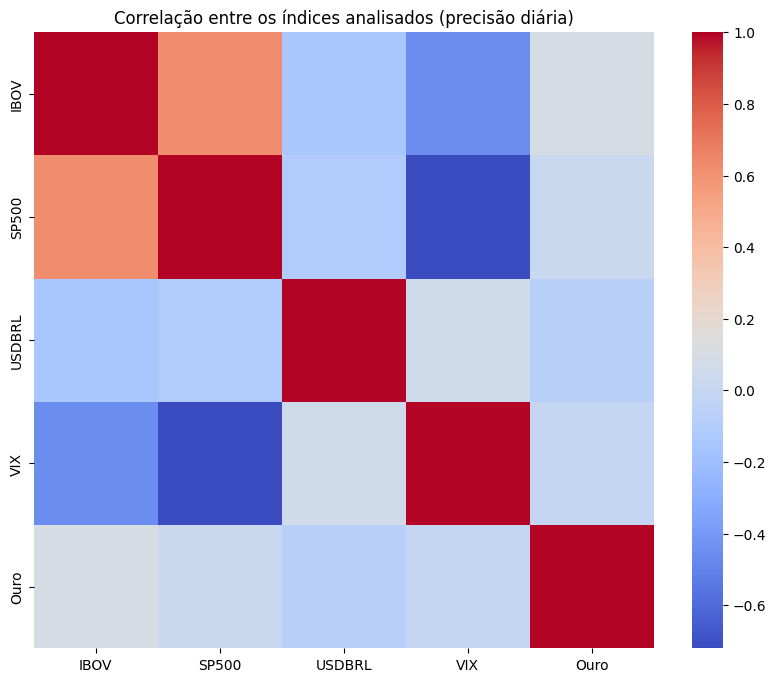

In [8]:
plt.figure(figsize=(10, 8))

sns.heatmap(new.corr(), cmap = "coolwarm")
plt.title("Correlação entre os índices analisados (precisão diária)")

In [61]:
def vol(data, precisao): return data[f'retorno_{precisao}'].std() * np.sqrt(252)

arr = [bvsp, sp500, usdbrl, vix, gold]
arr_ipca = [bvsp, sp500, usdbrl, vix, gold, ipca]

def loop(precisao, arr_p = arr):
    volatilidades = []
    for index, ticker in zip(arr_p, tickers):
        volatilidades.append(vol(retornos(index, ticker), precisao))
    return volatilidades

volatilidades_diarias = loop("d")
volatilidades_mensais = loop("m")
volatilidades_anuais = loop("a")

<BarContainer object of 5 artists>

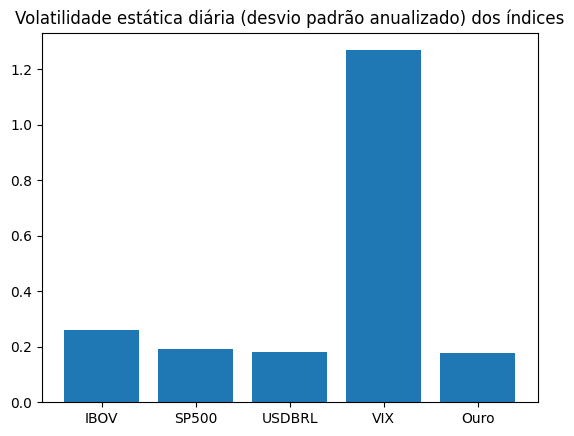

In [62]:
plt.title("Volatilidade estática diária (desvio padrão anualizado) dos índices")
plt.bar(tickers, volatilidades_diarias)

In [64]:
ipca = ipca.dropna().applymap(lambda x : float(str(x).replace("--", str(np.nan)).replace(",", ".").replace("%", "")) / 100)

C:\Users\arthu\AppData\Local\Temp\ipykernel_27796\2850255073.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ipca = ipca.dropna().applymap(lambda x : float(str(x).replace("--", str(np.nan)).replace(",", ".").replace("%", "")) / 100)


In [70]:
volatilidades_mensais.append(ipca.std(axis = 0).mean() * np.sqrt(252))
volatilidades_anuais.append(ipca.std(axis = 1).mean() * np.sqrt(252))

Vol. mensal média do IPCA: 1.61e-11


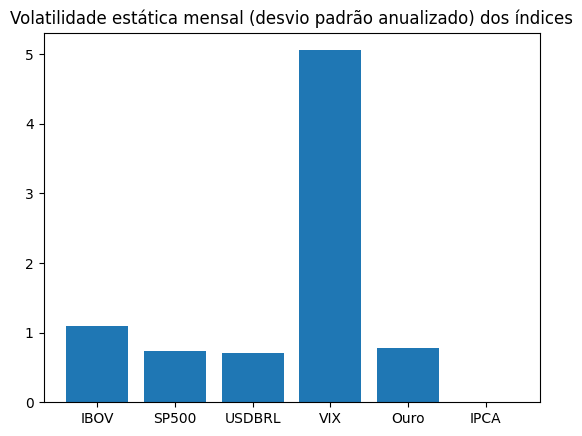

In [69]:
plt.title("Volatilidade estática mensal (desvio padrão anualizado) dos índices")

plt.bar([*tickers, "IPCA"], volatilidades_mensais)
print(f"Vol. mensal média do IPCA: {volatilidades_mensais[-1]:.2e}")

Vol. anual média do IPCA: 8.53e-09


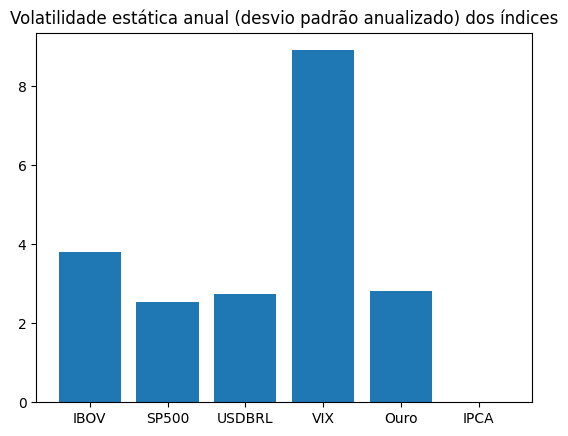

In [73]:
plt.title("Volatilidade estática anual (desvio padrão anualizado) dos índices")
plt.bar([*tickers, "IPCA"], volatilidades_anuais)
print(f"Vol. anual média do IPCA: {volatilidades_anuais[-1]:.2e}")

Com isso, fica visível que, em praticamente todos os períodos analisados, o IPCA se mostra o índice com menor volatilidade, o que pode ser usado como uma métrica para risco. 

Uma outra métrica para quantificar o risco associado com cada índice seria uma espécie de índice de Sharpe, 

$\text{Coef. var.} := \frac{\sigma_{\text{Móvel}}}{\mu_\text{Móvel}}$, onde podemos tomar uma janela de 12 meses na resolução mensal, à fim de incorporar os dados do IPCA.  

In [ ]:
def diario_para_mensal(df_diario, coluna_valor):
    """
    Transforma dados diários em mensais
    """
    df_mensal = pd.DataFrame()
    
    # Último valor do mês (comum em finanças)                       
    df_mensal['fechamento'] = df_diario[coluna_valor].resample('ME').last();
    
    # Média do mês                                                                                                                                      
    df_mensal['media'] = df_diario[coluna_valor].resample('ME').mean();
    
    # Soma do mês (útil para acumulado)                                                                                                         
    df_mensal['soma'] = df_diario[coluna_valor].resample('ME').sum();
    
    # Volatilidade mensal (desvio padrão)                               
    df_mensal['volatilidade'] = df_diario[coluna_valor].resample('ME').std();
    
    # Retorno mensal (se for taxa de variação)                          
    df_mensal['retorno'] = df_diario[coluna_valor].resample('ME').last().pct_change();
    
    return df_mensal

bvsp_mensal = diario_para_mensal(bvsp, "Close")
sp500_mensal = diario_para_mensal(sp500, "Close")
usdbrl_mensal = diario_para_mensal(usdbrl, "Close")
vix_mensal = diario_para_mensal(vix, "Close")
gold_mensal = diario_para_mensal(gold, "Close")
ipca_mensal = diario_para_mensal(ipca)

In [75]:
def coef_var_movel(serie, window = 12):

    media_movel = serie.rolling(window = window).mean()
    desv_pad_movel = serie.rolling(window = window).std()

    cv_movel = desv_pad_movel / media_movel.abs()

    return media_movel, desv_pad_movel, cv_movel

In [114]:
coef_var_bvsp = coef_var_movel(bvsp_mensal)[2]["fechamento"]
coef_var_sp500 = coef_var_movel(sp500_mensal)[2]["fechamento"]
coef_var_usdbrl = coef_var_movel(usdbrl_mensal)[2]["fechamento"]
coef_var_vix = coef_var_movel(vix_mensal)[2]["fechamento"]
coef_var_gold = coef_var_movel(gold_mensal)[2]["fechamento"]

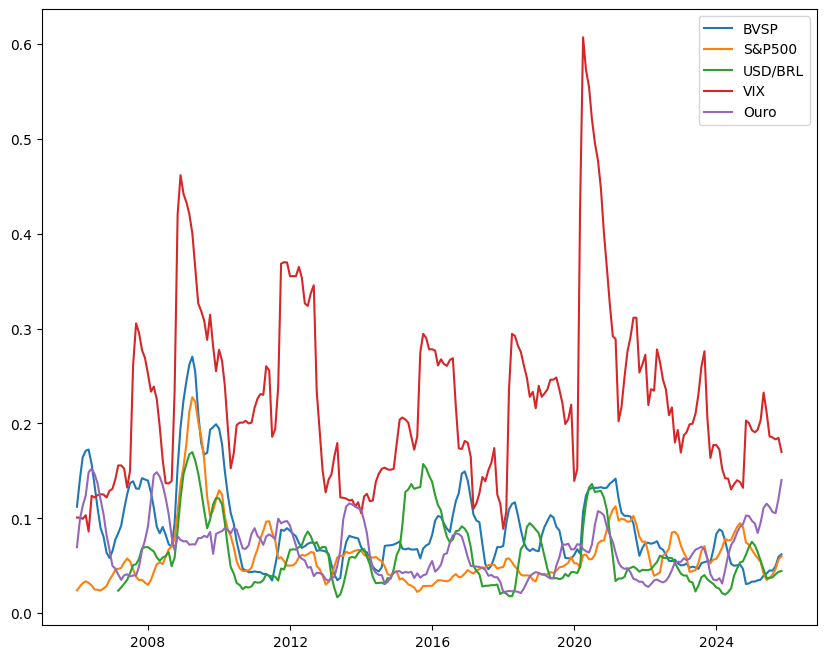

In [119]:
plt.figure(figsize=(10, 8))
plt.plot(coef_var_bvsp, label = "BVSP")
plt.plot(coef_var_sp500, label = "S&P500")
plt.plot(coef_var_usdbrl, label = "USD/BRL")
plt.plot(coef_var_vix, label = "VIX")
plt.plot(coef_var_gold, label = "Ouro")
plt.legend()

In [124]:
print(f"BVSP: {coef_var_bvsp.mean():.4f}")
print(f"S&P500: {coef_var_sp500.mean():.4f}")
print(f"USD/BRL: {coef_var_usdbrl.mean():.4f}")
print(f"VIX: {coef_var_vix.mean():.4f}")
print(f"Ouro: {coef_var_gold.mean():.4f}")

BVSP: 0.0888
S&P500: 0.0615
USD/BRL: 0.0631
VIX: 0.2253
Ouro: 0.0670


Como o VIX possuiu o maior coeficiente, vamos tomar o VIX como sendo o de maior risco. 